# Imports

In [1]:
import warnings
from collections import Counter

import numpy as np
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm.notebook import tqdm
from umap import UMAP
from wordcloud import WordCloud, get_single_color_func

from khan_helpers import Experiment
from khan_helpers.constants import (
    BOS_LECTURE_COLOR,
    BOS_QUESTION_COLOR, 
    EMBS_DIR, 
    FIG_DIR, 
    FONTS_DIR,
    FORCES_LECTURE_COLOR,
    FORCES_QUESTION_COLOR,
    GENERAL_QUESTION_COLOR,
    MODELS_DIR,
    RAW_DIR,
    WORDLE_COLORS
)
from khan_helpers.functions import (
    correlation_exp, 
    interp_lecture,
    multicol_display, 
    rbf_sum, 
    show_source
)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define/inspect some functions & classes

### constructing knowledge maps

In [2]:
show_source(correlation_exp)

In [3]:
show_source(rbf_sum)

In [4]:
def construct_knowledge_map(
    participant, 
    lecture, 
    quiz, 
    map_grid, 
    rbf_width, 
    rbf_metric='euclidean'
):
    assert isinstance(quiz, int), "Must select data from a single question set"
    lec_keys = {1: 'forces', 2: 'bos'}
    # coerce lecture arg type
    if hasattr(lecture, '__iter__') and not isinstance(lecture, str):
        # should always be in this order for consistency
        assert len(lecture) == 2 and lecture[0] in ('forces', 1) and lecture[1] in ('bos', 2)
        lecture = list(lecture)
    else:
        if isinstance(lecture, int):
            lecture = lec_keys[lecture]
        lecture = [lecture]
    
    map_vertices = map_grid.reshape(map_grid.shape[0] * map_grid.shape[1], 2)
    quiz_data = participant.get_data(lecture=lecture, quiz=quiz)
    qids_seen = quiz_data['qID']
    qids_correct = quiz_data.loc[quiz_data['accuracy'] == 1, 'qID']
    qembs_seen = questions_embeddings[qids_seen - 1]
    qembs_correct = questions_embeddings[qids_correct - 1]
    
    _weights_map = rbf_sum(obs_coords=qembs_seen,
                           pred_coords=map_vertices,
                           width=rbf_width,
                           metric=rbf_metric)
    weights_map = _weights_map / _weights_map.max()
    
    raw_map = rbf_sum(obs_coords=qembs_correct,
                      pred_coords=map_vertices,
                      width=rbf_width,
                      metric=rbf_metric)
    raw_map /= _weights_map.max()
    
    return (raw_map / weights_map).reshape(map_grid.shape[:2])

### Creating and plotting wordles

In [5]:
def get_word_weights(topic_proportions, reference_data, topic_model):
    ndim_in = topic_proportions.ndim
    topic_proportions = np.atleast_2d(topic_proportions)
    
    word_weights = np.dot(topic_proportions, topic_model.components_)
    ref_weights = np.dot(reference_data, topic_model.components_)
    
    word_weights -= ref_weights.mean(axis=0)

    word_weights -= word_weights.min(axis=1, keepdims=True)
    word_weights /= word_weights.max(axis=1, keepdims=True)

    if ndim_in == 1:
        word_weights = word_weights.squeeze()
    
    return word_weights

In [6]:
class InterpColorFunc:
    def __init__(
        self, 
        forces_weights, 
        bos_weights, 
        forces_color=None, 
        bos_color=None, 
        mid_color=None, 
        cmap=None, 
        n_colors=500
    ):
        self.forces_weights = forces_weights
        self.bos_weights = bos_weights
        if isinstance(cmap, (mpl.colors.Colormap, sns.palettes._ColorPalette)):
            self.cmap = cmap
            if any(
                arg is not None for arg in (forces_color, bos_color, mid_color)
            ):
                warnings.warn('`forces_color`, `bos_color`, and `mid_color` '
                              'arguments are ignored when passing a `cmap`')
        elif cmap is None:
            if forces_color is None or bos_color is None:
                raise ValueError('must pass either `cmap` or both '
                                 '`forces_color` and `bos_color`')
            elif mid_color is None:
                colors = [mpl.colors.to_rgb(forces_color), 
                          mpl.colors.to_rgb(bos_color)],
            else:
                colors = [mpl.colors.to_rgb(forces_color), 
                          mpl.colors.to_rgb(mid_color), 
                          mpl.colors.to_rgb(bos_color)]
            self.cmap = LinearSegmentedColormap.from_list('WordleInterpCmap', 
                                                          colors=colors, 
                                                          N=n_colors)
        else:
            raise TypeError('bad cmap arg')
        
    def __call__(self, word, *args, **kwargs):
        word_forces_weight = self.forces_weights[word]
        word_bos_weight = self.bos_weights[word]
        forces_weight_prop = word_forces_weight / (word_forces_weight + word_bos_weight)
        
        if isinstance(self.cmap, sns.palettes._ColorPalette):
            cmap_index = len(self.cmap) - round(len(self.cmap) * forces_weight_prop)
            r, g, b = [f"{round(i * 100)}%" for i in self.cmap[cmap_index]]
        else:
            cmap_index = self.cmap.N - round(self.cmap.N * forces_weight_prop)
            r, g, b, a = self.cmap(cmap_index, bytes=True)
        
        return f"rgb({r}, {g}, {b})"

In [7]:
def plot_wordle(
    textdict, 
    color_func=None, 
    mask=None, 
    stopwords=None, 
    border=False,
    border_color='black',
    border_width=1,
    border_pad=1,
    ax=None,
    **kwargs
):
    if stopwords is not None:
        if isinstance(stopwords, str):
            stopwords = [stopwords]
        for sw in stopwords:
            textdict.pop(sw, None)
            
    wc = WordCloud(max_font_size=kwargs.pop('max_font_size', 50), 
                   collocations=False, 
                   background_color=kwargs.pop('background_color', 'white'), 
                   mask=mask, 
                   width=2000, 
                   height=1000,
                   color_func=color_func,
                   relative_scaling=kwargs.pop('relative_scaling', 1),
                   **kwargs)
    wc.generate_from_frequencies(textdict)
    if ax is None:
        ax = plt.gca()

    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    
    if border:
        border = Circle((wc.width/2, wc.height/2), 
                        radius=wc.height/2 + border_pad, 
                        color=border_color, 
                        linewidth=border_width, 
                        fill=False, 
                        clip_on=False)
        ax.add_patch(border)
    
    return wc

# Set constants

In [8]:
KMAPS_FIG_DIR = FIG_DIR.joinpath('knowledge-maps-components')
KMAPS_FIG_DIR.mkdir(exist_ok=True)

RANDOM_STATE = 15
GRID_RESOLUTION = 100
RBF_WIDTH = 50
WORDLE_N_WORDS = 50
WORDLE_FONT_PATH = FONTS_DIR.joinpath('Myriad Pro Regular.ttf')

if not WORDLE_FONT_PATH.is_file():
    warnings.warn("Unfortunately, Adobe's font license does not allow us to "
                  "share the font file in this repository (though it's not "
                  "hard to find online). If you want to reproduce the wordle "
                  "figure with the same font we used (or a different one), "
                  "add the file to the data/fonts/ folder and make sure its "
                  "name matches the file name in this cell. Or, ignore this "
                  "warning to use the wordcloud package's default font.")

# Load data

In [9]:
exp = Experiment()

forces_windows = exp.forces_windows
bos_windows = exp.bos_windows
forces_timestamps = exp.forces_timestamps
bos_timestamps = exp.bos_timestamps
quiz_text_processsed = np.load(RAW_DIR.joinpath('quiz_text_processed.npy'))

# Create 2D embeddings

In [10]:
# Project text into 100 dimensions for better embedding
corpus = np.concatenate((exp.forces_windows, exp.bos_windows))
cv = CountVectorizer()
lda = LatentDirichletAllocation(n_components=100, random_state=0)
lda.fit(cv.fit_transform(corpus))

forces_lecture_100d = interp_lecture(lda.transform(cv.transform(forces_windows)), 
                                     forces_timestamps)
bos_lecture_100d = interp_lecture(lda.transform(cv.transform(bos_windows)), 
                                  bos_timestamps)
questions_100d = lda.transform(cv.transform(quiz_text_processsed[:, 0]))

# fit UMAP model to both lectures & all questions to embed in common space
to_reduce = [forces_lecture_100d, bos_lecture_100d, questions_100d]

# store incidces to separate embedding data later
split_inds = np.cumsum([np.atleast_2d(vec).shape[0] for vec in to_reduce])[:2]

# log-transform, concatenate along feature dimension
to_reduce = np.log(np.vstack(to_reduce))

In [11]:
np.random.seed(RANDOM_STATE)
reducer = UMAP(metric=correlation_exp, 
               random_state=RANDOM_STATE, 
               verbose=True).fit(to_reduce)
embeddings = reducer.embedding_
(forces_embedding, 
 bos_embedding, 
 questions_embeddings) = np.vsplit(embeddings, split_inds)

UMAP(metric=CPUDispatcher(<function correlation_exp at 0xffff566ca550>), random_state=15, verbose=True)
Fri Jan 27 05:43:23 2023 Construct fuzzy simplicial set
Fri Jan 27 05:43:26 2023 Finding Nearest Neighbors
Fri Jan 27 05:43:27 2023 Finished Nearest Neighbor Search
Fri Jan 27 05:43:28 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Jan 27 05:43:30 2023 Finished embedding


In [12]:
# save fit UMAP reducer and 2D embeddings
# np.save(MODELS_DIR.joinpath('fit_UMAP'), reducer)
# np.save(EMBS_DIR.joinpath('forces_lecture'), forces_embedding)
# np.save(EMBS_DIR.joinpath('bos_lecture'), bos_embedding)
# np.save(EMBS_DIR.joinpath('questions'), questions_embeddings)

# Create a 2D grid over the embedding space

In [13]:
# pad grid a little bit so extreme points aren't on edges of plot
x_min, y_min = embeddings.min(axis=0) // 1 - 3
x_max, y_max = embeddings.max(axis=0) // 1 + 3

xs = np.linspace(x_min, x_max, GRID_RESOLUTION, endpoint=True)
ys = np.linspace(y_min, y_max, GRID_RESOLUTION, endpoint=True)

X, Y = np.meshgrid(xs, ys)
xy_grid = np.empty((GRID_RESOLUTION, GRID_RESOLUTION, 2), dtype=np.float64)
for (x_ix, y_ix), X_val in np.ndenumerate(X):
    xy_grid[x_ix, y_ix] = (X_val, Y[x_ix, y_ix])
    
vertices = xy_grid.reshape(GRID_RESOLUTION**2, 2)

# Recover topic vectors for some sample coordinates

In [14]:
# choose some locations for displaying word clouds
wordle_coords = np.array([[-1, -8], [9, 3], [20, 6]])

# inverse-transform coordinates into original topic space
np.random.seed(reducer.transform_seed)
wordle_vectors = np.array([reducer.inverse_transform(coord[None, :]) 
                           for coord in wordle_coords], 
                          dtype=np.float64).squeeze()

# undo log-transform & normalize
wordle_vectors = np.exp(wordle_vectors)
wordle_vectors /= wordle_vectors.sum(axis=1, keepdims=True)

Epochs completed:   0%|            0/100 [00:00]

Epochs completed:   0%|            0/100 [00:00]

Epochs completed:   0%|            0/100 [00:00]

# Construct knowledge maps from memory traces for embedded lectures

In [15]:
maps_arr = np.empty((3, len(exp.participants), GRID_RESOLUTION, GRID_RESOLUTION), 
                    dtype=np.float64)

pbar = tqdm(total=len(exp.participants)*3, leave=False)
for quiz in range(3):
    store_key = f'forces_bos_quiz{quiz + 1}'
    for i, p in enumerate(exp.participants):
        # known values are knowledge traces for BOTH lectures
        kmap = construct_knowledge_map(p,
                                       lecture=('forces', 'bos'),
                                       quiz=quiz,
                                       map_grid=xy_grid,
                                       rbf_width=RBF_WIDTH,
                                       rbf_metric='euclidean')
        p.store_kmap(kmap, store_key)
        maps_arr[quiz, i] = kmap
        pbar.update()
        
    # store average in avg participant
    exp.avg_participant.store_kmap(maps_arr[quiz].mean(axis=0), store_key)
pbar.close()

  0%|          | 0/150 [00:00<?, ?it/s]

In [16]:
# save updated participant objects
# exp.save_participants(allow_overwrite=True)

In [17]:
# uniformly shift coordinates to line up with heatmap bounds for plotting
shifted_inds = np.append(split_inds, 
                         [split_inds[-1] + len(questions_embeddings), 
                          split_inds[-1] + len(questions_embeddings) + len(wordle_coords)])
coords = np.vstack((embeddings, wordle_coords, vertices))
coords_shifted = coords - coords.min(axis=0)
coords_shifted /= (coords_shifted.max(axis=0) / GRID_RESOLUTION)
(
    forces_shifted, 
    bos_shifted, 
    questions_shifted, 
    wordle_coords_shifted, 
    _
) = np.vsplit(coords_shifted, shifted_inds)

# make sure split happened at correct indices
assert len(forces_shifted) == len(forces_embedding)
assert len(bos_shifted) == len(bos_embedding)
assert len(questions_shifted) == len(questions_embeddings)
assert len(wordle_coords_shifted) == len(wordle_coords)

ff_qs_shifted = questions_shifted[:15]
bos_qs_shifted = questions_shifted[15:30]
gen_qs_shifted = questions_shifted[30:]

# Plot knowledge and learning maps

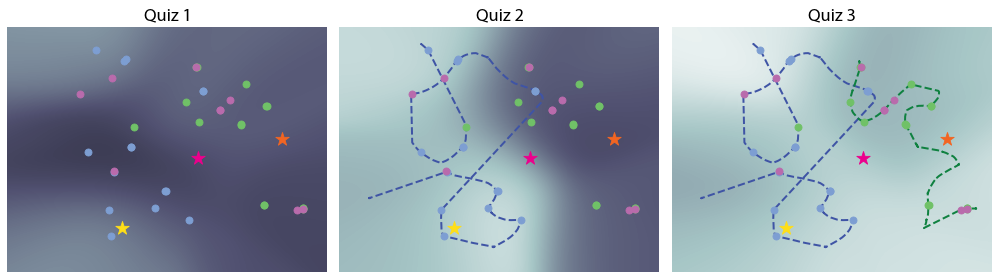

In [18]:
with sns.plotting_context('paper', font_scale=1.1):
    cmap = 'bone'
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(14, 4)
    
    for i, ax in enumerate(axes):
        # knowledge estimate heatmap
        kmap = exp.avg_participant.get_kmap(f'forces_bos_quiz{i + 1}')
        sns.heatmap(kmap, 
                    vmin=0, 
                    vmax=1, 
                    cmap=cmap, 
                    xticklabels=[], 
                    yticklabels=[], 
                    cbar=False, 
                    ax=ax)            
        ax.collections[0].remove()
        ax.imshow(kmap,
                  vmin=0,
                  vmax=1,
                  aspect='auto',
                  cmap=cmap,
                  interpolation='bilinear')
        # Four Fundamental Forces quiz questions
        ax.scatter(ff_qs_shifted[:, 0],
                   ff_qs_shifted[:, 1],
                   c=FORCES_QUESTION_COLOR,
                   marker='o',
                   s=50,
                   zorder=2)
        # Birth of Stars quiz questions
        ax.scatter(bos_qs_shifted[:, 0], 
                   bos_qs_shifted[:, 1], 
                   c=BOS_QUESTION_COLOR, 
                   marker='o', 
                   s=50, 
                   zorder=2)
        # general physics knowledge quiz questions
        ax.scatter(gen_qs_shifted[:, 0],
                   gen_qs_shifted[:, 1],
                   c=GENERAL_QUESTION_COLOR,
                   marker='o',
                   s=50,
                   zorder=2)
        # Four Fundamental Forces lecture trajectory
        if i > 0:
            ax.plot(forces_shifted[:, 0], 
                    forces_shifted[:, 1], 
                    c=FORCES_LECTURE_COLOR,
                    linestyle='--', 
                    linewidth=2, 
                    zorder=1)
            # Birth of Stars lecture trajectory
            if i > 1:
                ax.plot(bos_shifted[:, 0], 
                        bos_shifted[:, 1], 
                        c=BOS_LECTURE_COLOR,
                        linestyle='--',
                        linewidth=2, 
                        zorder=1)
                
        # wordle coordinates
        for coord, color in zip(wordle_coords_shifted, WORDLE_COLORS):
            ax.scatter(coord[0], coord[1], c=color, marker='*', s=200)

        ax.set_title(f'Quiz {i + 1}', fontsize='xx-large')
        # undo automatic y-axis inversion from sns.heatmap
        ax.invert_yaxis()
    
    plt.tight_layout() 
#     plt.savefig(KMAPS_FIG_DIR.joinpath('knowledge_maps.pdf'), 
#                 dpi=1000, 
#                 bbox_inches='tight')
    plt.show()

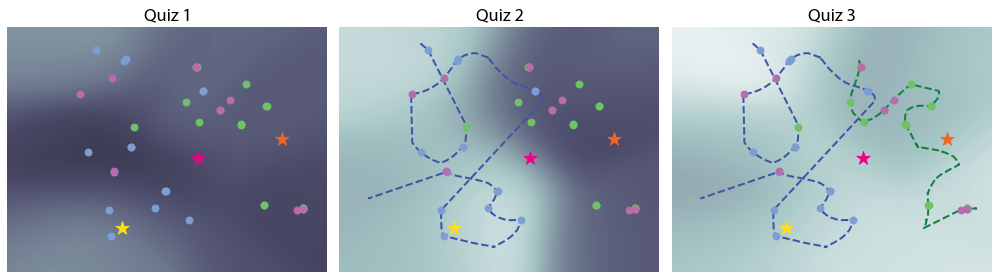

In [19]:
with sns.plotting_context('paper', font_scale=1.1):
    cmap = 'bone'
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(14, 4)
    
    for i, ax in enumerate(axes):
        # knowledge estimate heatmap
        kmap = exp.avg_participant.get_kmap(f'forces_bos_quiz{i + 1}')
        sns.heatmap(kmap, 
                    vmin=0, 
                    vmax=1, 
                    cmap=cmap, 
                    xticklabels=[], 
                    yticklabels=[], 
                    cbar=False, 
                    ax=ax)            
        ax.collections[0].remove()
        ax.imshow(kmap,
                  vmin=0,
                  vmax=1,
                  aspect='auto',
                  cmap=cmap,
                  interpolation='bilinear')
        ax.axis('off')
        # Four Fundamental Forces quiz questions
        ax.scatter(ff_qs_shifted[:, 0],
                   ff_qs_shifted[:, 1],
                   c=FORCES_QUESTION_COLOR,
                   marker='o',
                   s=50,
                   zorder=2)
        # Birth of Stars quiz questions
        ax.scatter(bos_qs_shifted[:, 0], 
                   bos_qs_shifted[:, 1], 
                   c=BOS_QUESTION_COLOR, 
                   marker='o', 
                   s=50, 
                   zorder=2)
        # general physics knowledge quiz questions
        ax.scatter(gen_qs_shifted[:, 0],
                   gen_qs_shifted[:, 1],
                   c=GENERAL_QUESTION_COLOR,
                   marker='o',
                   s=50,
                   zorder=2)
        # Four Fundamental Forces lecture trajectory
        if i > 0:
            ax.plot(forces_shifted[:, 0], 
                    forces_shifted[:, 1], 
                    c=FORCES_LECTURE_COLOR,
                    linestyle='--', 
                    linewidth=2, 
                    zorder=1)
            # Birth of Stars lecture trajectory
            if i > 1:
                ax.plot(bos_shifted[:, 0], 
                        bos_shifted[:, 1], 
                        c=BOS_LECTURE_COLOR,
                        linestyle='--',
                        linewidth=2, 
                        zorder=1)
                
        # wordle coordinates
        for coord, color in zip(wordle_coords_shifted, WORDLE_COLORS):
            ax.scatter(coord[0], coord[1], c=color, marker='*', s=200)

        ax.set_title(f'Quiz {i + 1}', fontsize='xx-large')
        # undo automatic y-axis inversion from sns.heatmap
        ax.invert_yaxis()
    
    plt.tight_layout() 
#     plt.savefig(KMAPS_FIG_DIR.joinpath('knowledge_maps.pdf'), 
#                 dpi=1000, 
#                 bbox_inches='tight')
    plt.show()

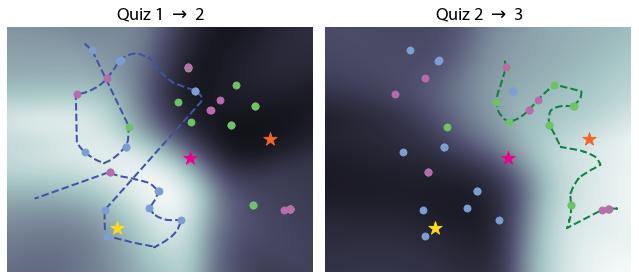

In [20]:
with sns.plotting_context('paper', font_scale=1.1):
    cmap = 'bone'
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(9, 4)
    
    for i, ax in enumerate(axes):
        # learning estimate heatmap
        before = exp.avg_participant.get_kmap(f'forces_bos_quiz{i + 1}')
        after = exp.avg_participant.get_kmap(f'forces_bos_quiz{i + 2}')
        learning_map = after - before
        sns.heatmap(learning_map, 
                    vmin=-0.1, 
                    vmax=0.5, 
                    cmap=cmap, 
                    xticklabels=[], 
                    yticklabels=[], 
                    cbar=False, 
                    ax=ax)
        ax.collections[0].remove()
        ax.imshow(learning_map, 
                  vmin=-0.1, 
                  vmax=0.5,
                  aspect='auto', 
                  cmap=cmap, 
                  interpolation='bilinear')
        ax.axis('off')
        # Four Fundamental Forces quiz questions
        ax.scatter(ff_qs_shifted[:, 0], 
                   ff_qs_shifted[:, 1], 
                   c=FORCES_QUESTION_COLOR, 
                   marker='o', 
                   s=50,
                   zorder=2)
        # Birth of Stars quiz questions
        ax.scatter(bos_qs_shifted[:, 0], 
                   bos_qs_shifted[:, 1], 
                   c=BOS_QUESTION_COLOR, 
                   marker='o', 
                   s=50,
                   zorder=2)
        # general physics knowledge quiz questions
        ax.scatter(gen_qs_shifted[:, 0], 
                   gen_qs_shifted[:, 1], 
                   c=GENERAL_QUESTION_COLOR, 
                   marker='o', 
                   s=50,
                   zorder=2)
        # Four Fundamental Forces lecture trajectory
        if i == 0:
            ax.plot(forces_shifted[:, 0],
                    forces_shifted[:, 1],
                    c=FORCES_LECTURE_COLOR,
                    linestyle='--', 
                    linewidth=2, 
                    zorder=1)
        # Birth of Stars lecture trajectory
        else:
            ax.plot(bos_shifted[:, 0],
                    bos_shifted[:, 1],
                    c=BOS_LECTURE_COLOR,
                    linestyle='--',
                    linewidth=2, 
                    zorder=1)
            
        # wordle coordinates
        for coord, color in zip(wordle_coords_shifted, WORDLE_COLORS):
            ax.scatter(coord[0], coord[1], c=color, marker='*', s=200)

        ax.set_title(fr'Quiz {i + 1} $\rightarrow$ {i + 2}', 
                          fontsize='xx-large')
        # undo automatic y-axis inversion from sns.heatmap
        ax.invert_yaxis()

    plt.tight_layout()
#     plt.savefig(KMAPS_FIG_DIR.joinpath('learning_maps.pdf'), 
#                 dpi=1000, 
#                 bbox_inches='tight')
    plt.show()

# Create shared colorbar for knowldge & learning maps

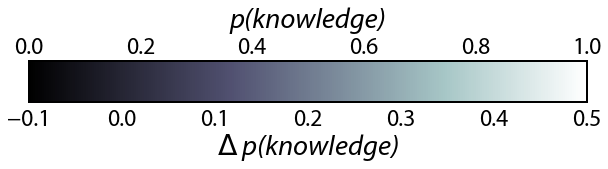

In [21]:
with sns.plotting_context('talk', font_scale=1.1):   
    fig, cax1 = plt.subplots(1, figsize=(10, 0.75))
    
    norm = mpl.colors.Normalize()
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap='bone')
    plt.colorbar(mappable, orientation='horizontal', cax=cax1)
    
    cax1.text(0.5, 1.7, 
              'p(knowledge)', 
              transform=cax1.transAxes, 
              fontsize='x-large', 
              fontstyle='italic',
              va='bottom', 
              ha='center')
    
    cax2 = cax1.twiny()
    cax2.set_xlim(-.1, 0.5)
    cax2.set_xticks(np.arange(-0.1, 0.6, 0.1))
    
    cax2.text(0.5, -0.7, 
              '$\mathit{\Delta}$ p(knowledge)', 
              transform=cax2.transAxes, 
              fontsize='x-large', 
              fontstyle='italic',
              va='top', 
              ha='center')
    
    cax1.tick_params(labeltop=True, bottom=False, labelbottom=False, labelsize='large', length=0)
    cax2.tick_params(top=False, labeltop=False, labelbottom=True, labelsize='large', length=0, pad=6)
    
#     plt.savefig(KMAPS_FIG_DIR.joinpath('knowledge-learning-maps-colorbar.pdf'), bbox_inches='tight', dpi=1000)
    plt.show()

# Create wordles for sample points

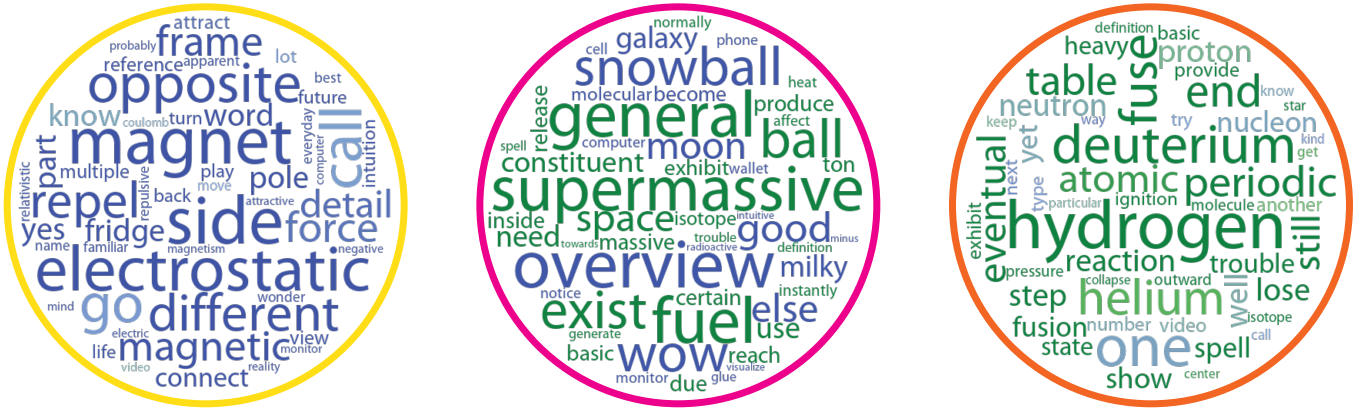

In [22]:
vocabulary = cv.get_feature_names_out()

# get each word's total weight across all timepoints of each lecture
forces_weightsum = np.dot(forces_lecture_100d, lda.components_).sum(axis=0)
forces_wordweights = dict(zip(vocabulary, forces_weightsum))
bos_weightsum = np.dot(bos_lecture_100d, lda.components_).sum(axis=0)
bos_wordweights = dict(zip(vocabulary, bos_weightsum))

# get weights over corpus words for each sample location's topic vector
reference_data = np.concatenate((forces_lecture_100d, 
                                 bos_lecture_100d, 
                                 questions_100d))
coords_wordweights = get_word_weights(wordle_vectors, reference_data, lda)

# create a colormap by linearly interpolating between the two lectures' 
# colors. Use question colors as waypoints to increase lightness.
cmap = LinearSegmentedColormap.from_list('WordleInterpCmap',
                                         [FORCES_LECTURE_COLOR,
                                          FORCES_QUESTION_COLOR,
                                          BOS_QUESTION_COLOR,
                                          BOS_LECTURE_COLOR],
                                         N=100)
# create a callable that will return a color for a given word in the 
# vocabulary based on its relative weight in the two lectures
color_func = InterpColorFunc(forces_weights=forces_wordweights, 
                             bos_weights=bos_wordweights, 
                             cmap=cmap)

if WORDLE_FONT_PATH.is_file():
    font_path = str(WORDLE_FONT_PATH)
else:
    font_path = None

fig, axarr =  plt.subplots(1, len(wordle_coords))
fig.set_size_inches(24, 8)

for i, coords in enumerate(coords_wordweights):
    weights_dict = dict(zip(vocabulary, coords))
    wc = plot_wordle(weights_dict, 
                     color_func=color_func, 
                     mask=exp.wordle_mask,
                     border=True,
                     border_color=WORDLE_COLORS[i],
                     border_width=7,
                     border_pad=2,
                     ax=axarr[i], 
                     random_state=0,
                     max_words=WORDLE_N_WORDS,
                     relative_scaling=1,
                     mode='RGBA',
                     font_path=font_path,
                     max_font_size=90,
                     background_color=None)
    
#     with open(KMAPS_FIG_DIR.joinpath(f'wordle{i+1}.svg'), 'w') as f:
#         f.write(wc.to_svg(embed_font=False))
plt.show()

# Create colorbar for wordles

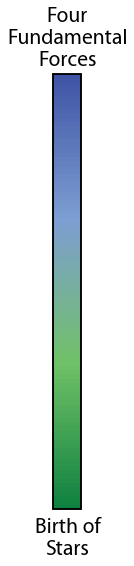

In [23]:
with sns.plotting_context('talk'):   
    fig, cax = plt.subplots(1, figsize=(0.5, 8))
    
    norm = mpl.colors.Normalize()
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap.reversed())
    plt.colorbar(mappable, cax=cax)
    
    cax.text(0.5, 1.01, 
             'Four\nFundamental\nForces', 
             transform=cax.transAxes, 
             fontsize='large', 
             va='bottom', 
             ha='center')
    cax.text(0.5, -0.02, 
             'Birth of\nStars', 
             transform=cax.transAxes, 
             fontsize='large', 
             va='top', 
             ha='center')
    cax.tick_params(right=False, labelright=False)
#     plt.savefig(KMAPS_FIG_DIR.joinpath('wordle-colorbar.pdf'), bbox_inches='tight', dpi=1000)
    plt.show()